In [1]:
import math
import bilby
import scipy
import pycbc
import pickle
import deepdish
import pycbc.psd
import gwpopulation

import numpy as np
import pandas as pd
import scipy.signal as sig
import matplotlib.pyplot as plt
from pycbc.types import TimeSeries
from pycbc.waveform import get_fd_waveform

from matplotlib import rcParams
rcParams.update({'text.usetex' : True})
%matplotlib inline 

In [2]:
result=bilby.core.result.read_in_result('data/GWTC-3-population-data/analyses/PowerLawPeak/o1o2o3_mass_c_iid_mag_iid_tilt_powerlaw_redshift_result.json')
alpha=result.posterior['alpha']
beta=result.posterior['beta']
lam=result.posterior['lam']
mpp=result.posterior['mpp']
sigpp=result.posterior['sigpp']
delta_m=result.posterior['delta_m']
mu_chi=result.posterior['mu_chi']
sigma_chi=result.posterior['sigma_chi']
xi_spin=result.posterior['xi_spin']
sigma_spin=result.posterior['sigma_spin']
lamb=result.posterior['lamb']
amax=result.posterior['amax']

n_map=np.argmax(result.posterior['log_likelihood']+result.posterior['log_prior'])
PP_params = {
    "alpha": alpha[n_map],
    "beta": beta[n_map],
    "mmin": 5,
    "mmax": 100,
    "lam": lam[n_map],
    "mpp": mpp[n_map],
    "sigpp": sigpp[n_map],
    "delta_m": delta_m[n_map],
    "mu_chi": mu_chi[n_map],
    "sigma_chi": sigma_chi[n_map],
    "xi_spin": xi_spin[n_map],
    "sigma_spin": sigma_spin[n_map],
    "lamb": lamb[n_map],
    "amax": amax[n_map]
}

In [3]:
params = PP_params.copy()
p, _ = gwpopulation.conversions.convert_to_beta_parameters(params)

num_samples = 10000
mass = np.linspace(5, 100, num=num_samples)
q = np.linspace(0, 1, num=num_samples)
z = np.linspace(1e-3, 2.3, num=num_samples)
cos_tilt_1 = np.linspace(-1, 1, num=num_samples)
cos_tilt_2 = np.linspace(-1, 1, num=num_samples) 
a_1 = np.linspace(0, 0.8, num=num_samples)
a_2 = np.linspace(0, 0.8, num=num_samples)

mass_model = gwpopulation.models.mass.SinglePeakSmoothedMassDistribution(mmin=5, mmax=100)
p_mass = mass_model.p_m1(
    dataset=pd.DataFrame(dict(mass_1=mass)),
    alpha=p["alpha"],
    mmin=p["mmin"],
    mmax=p["mmax"],
    lam=p["lam"],
    mpp=p["mpp"],
    sigpp=p["sigpp"],
    delta_m=p["delta_m"]
)
p_q = mass_model.p_q(
    dataset=pd.DataFrame(dict(mass_ratio=q, mass_1=mass)),
    beta=p["beta"],
    mmin=p["mmin"],
    delta_m=p["delta_m"]
)
p_z = gwpopulation.models.redshift.PowerLawRedshift(z_max=2.3).probability(
    dataset=pd.DataFrame(dict(redshift=z)), lamb=p["lamb"]
)
p_a = gwpopulation.models.spin.iid_spin_magnitude_beta(
    dataset=pd.DataFrame(dict(a_1=a_1, a_2=a_2)),
    amax=p["amax"],
    alpha_chi=p["alpha_chi"],
    beta_chi=p["beta_chi"]
)
p_cos_tilt_1 = gwpopulation.models.spin.truncnorm(
    xx=cos_tilt_1, mu=1, sigma=p["sigma_spin"], high=1, low=-1
)
p_cos_tilt_2 = gwpopulation.models.spin.truncnorm(
    xx=cos_tilt_2, mu=1, sigma=p["sigma_spin"], high=1, low=-1
)

/home/nishkal/.local/lib/python3.10/site-packages/gwpopulation/models/mass.py:634: RuntimeWarning: overflow encountered in exp
  window[smoothing_region] = 1 / (xp.exp(exponent) + 1)
/home/nishkal/.local/lib/python3.10/site-packages/gwpopulation/models/mass.py:632: RuntimeWarning: divide by zero encountered in divide
  delta_m / shifted_mass + delta_m / (shifted_mass - delta_m)
/home/nishkal/.local/lib/python3.10/site-packages/gwpopulation/utils.py:76: RuntimeWarning: divide by zero encountered in divide
  norm = (1 + alpha) / (high ** (1 + alpha) - low ** (1 + alpha))
/home/nishkal/.local/lib/python3.10/site-packages/gwpopulation/utils.py:79: RuntimeWarning: invalid value encountered in multiply
  prob *= (xx <= high) & (xx >= low)
/home/nishkal/.local/lib/python3.10/site-packages/gwpopulation/models/mass.py:582: RuntimeWarning: invalid value encountered in multiply
  p_q *= self.smoothing(
/home/nishkal/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning:

In [4]:
priors = bilby.prior.PriorDict(
    dict(
        mass_1_source=bilby.core.prior.Interped( #Primary mass of the binary in source frame
            mass,
            p_mass,
            minimum=5,
            maximum=100,
            name="mass_1_source",
            latex_label="$m_{1}$",
        ),
        mass_ratio=bilby.core.prior.Interped( #Mass ratio of the binaries
            q,
            p_q,
            minimum=0,
            maximum=1,
            name="mass_ratio",
            latex_label="$q$",
        ),
        redshift=bilby.core.prior.Interped( #Redshifted distance
            z,
            p_z,
            minimum=0,
            maximum=2.3,
            name="redshift",
            latex_label="$pred_z$",
        ),
        psi=bilby.core.prior.Uniform( #The polarization angle as defined with respect to the total angular momentum
            name="psi", 
            minimum=0, 
            maximum=np.pi, 
            boundary="periodic",
            latex_label="$\\psi_j$",
        ),
        a_1=bilby.core.prior.Interped( #The spin magnitude on the larger object
            a_1,
            p_a,
            minimum=0,
            maximum=1,
            name="a_1",
            latex_label="$a_1$",
        ),
        a_2=bilby.core.prior.Interped( #The spin magnitude on the secondary object
            a_2,
            p_a,
            minimum=0,
            maximum=1,
            name="a_2",
            latex_label="$a_2$",
        ),
        cos_tilt_1=bilby.core.prior.Interped( #The angle between the total orbital angular momentum and the primary spin
            cos_tilt_1,
            p_cos_tilt_1,
            minimum=-1,
            maximum=1,
            name="cos_tilt_1",
            latex_label="$\\cos\ \\mathrm{tilt}_1$",
        ),
        cos_tilt_2=bilby.core.prior.Interped( #The angle between the total orbital angular momentum and the secondary spin
            cos_tilt_2,
            p_cos_tilt_2,
            minimum=-1,
            maximum=1,
            name="cos_tilt_2",
            latex_label="$\\cos\ \\mathrm{tilt}_2$",
        ),
        phi_12=bilby.core.prior.Uniform( #The angle between the primary spin and the secondary spin
            name="phi_12",
            minimum=0,
            maximum=2 * np.pi,
            boundary="periodic",
            latex_label="$\\phi_{12}$",
        ),
        cos_theta_jn=bilby.core.prior.Uniform( #The angle between the total orbital angular momentum and the line of sight
            name="cos_theta_jn",
            minimum=-1,
            maximum=1,
            boundary="periodic",
            latex_label="$\\cos\\theta_{jn}$",
        ),
        ra=bilby.core.prior.Uniform( #The right ascension of the source
            name="ra", 
            minimum=0, 
            maximum=2 * np.pi, 
            boundary="periodic",
            latex_label="$ra$",
        ),
        dec=bilby.core.prior.Cosine( #The declination of the source
            name="dec", 
            latex_label="$dec$",
        ),
        phi_jl=bilby.core.prior.Uniform( #The precession phase
            name="phi_jl",
            minimum=0,
            maximum=2 * np.pi,
            boundary="periodic",
            latex_label="$\\phi_{jl}$",
        ),
        incl=bilby.core.prior.Uniform( #The source inclination angle
            name="incl", 
            minimum=0, 
            maximum=2 * np.pi, 
            boundary="periodic",
            latex_label="$\\iota$",  
        ),
        phase=bilby.core.prior.Uniform( #The coalescence phase
            name="phase", 
            minimum=0, 
            maximum=2 * np.pi, 
            boundary="periodic",
            latex_label="$\\phi$",  
        )
    )
)

In [5]:
num_inject = int(1e2)

injections = pd.DataFrame(priors.sample(num_inject)).to_dict("list")

z = injections.get("redshift", [])
injections["mass_1"] = injections["mass_1_source"] * (1 + np.array(z))
injections["mass_2"] = injections["mass_1"] * injections["mass_ratio"]

injections["luminosity_distance"] = bilby.gw.conversion.redshift_to_luminosity_distance(z)

injections["tilt_1"] = np.arccos(injections["cos_tilt_1"])
injections["tilt_2"] = np.arccos(injections["cos_tilt_2"])
injections['theta_jn'] = np.arccos(injections["cos_theta_jn"])

injections["geocent_time"] = 1200000000

samples=pd.DataFrame(injections)
samples.to_hdf('output/injections.hdf5', key='injections')

In [6]:
duration = 100
minimum_frequency = 20
sampling_frequency = 4096

injection_parameters_a = []

for idx in range(0,len(injections["mass_1"])):
    injection_parameters_a.append(dict(deepdish.io.load('output/injections.hdf5')['injections'].loc[idx]))

    waveform_arguments = {
        'waveform_approximant': 'IMRPhenomPv2', #'SEOBNRv4PHM',
        'reference_frequency': 50,
        'minimum_frequency': 2
    }
    
    waveform_generator_a = bilby.gw.WaveformGenerator(
          duration=duration, sampling_frequency=sampling_frequency, start_time=injection_parameters_a[idx]['geocent_time']- duration + 2,
          frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
          waveform_arguments=waveform_arguments)

    ifos_a = bilby.gw.detector.InterferometerList(['H1', 'L1', 'V1'])

    for ifo in ifos_a:
        ifo.minimum_frequency = minimum_frequency
        ifo.maximum_frequency = sampling_frequency/2
        ifos_a.set_strain_data_from_zero_noise(   # set_strain_data_from_power_spectral_densities
        sampling_frequency=sampling_frequency, duration=duration,
        start_time=injection_parameters_a[idx]['geocent_time']- duration + 2)
    ifos_a.inject_signal(waveform_generator=waveform_generator_a, parameters=injection_parameters_a[idx])

    H1_a_snr = ifos_a.meta_data['H1']['optimal_SNR']
    L1_a_snr = ifos_a.meta_data['L1']['optimal_SNR']
    V1_a_snr = ifos_a.meta_data['V1']['optimal_SNR']
    net_a_snr = np.sqrt((H1_a_snr)**2 +(L1_a_snr)**2+(V1_a_snr)**2)
    
    if net_a_snr>8:
        break

with open('output/Waveform A Meta Data.pkl', 'wb') as file:
    pickle.dump(ifos_a.meta_data, file) 

19:16 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
19:16 bilby INFO    : Injected signal in H1:
19:16 bilby INFO    :   optimal SNR = 0.86
19:16 bilby INFO    :   matched filter SNR = 0.86+0.00j
19:16 bilby INFO    :   mass_1_source = 7.981805072952126
19:16 bilby INFO    :   mass_ratio = 0.7352095306883056
19:16 bilby INFO    :   redshift = 2.0053777486816524
19:16 bilby INFO    :   psi = 1.521618628493698
19:16 bilby INFO    :   a_1 = 0.2629930675687972
19:16 bilby INFO    :   a_2 = 0.04930425130284003
19:16 bilby INFO    :   cos_tilt_1 = 0.251499195547323
19:16 bilby INFO    :   cos_tilt_2 = 0.18224679568723495
19:16 bilby INFO    :   phi_12 = 5.22549397236288
19:16 bilby INFO    :   cos_theta_jn = -0.23242823705223392
19:16 bilby INFO    :   ra = 3.9110665893110323
19:16 bilby INFO    :  

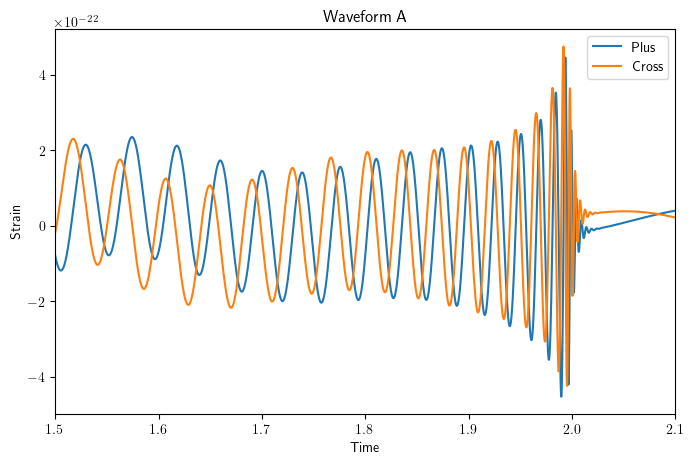

In [7]:
polarizations_td_a = waveform_generator_a.time_domain_strain(injection_parameters_a[len(injection_parameters_a)-1])
plus_td_a = np.roll(polarizations_td_a['plus'], int(sampling_frequency * 2))
cross_td_a = np.roll(polarizations_td_a['cross'], int(sampling_frequency * 2))
time = np.linspace(0, duration, len(plus_td_a))

fig = plt.figure(figsize=(8, 5))

plt.plot(time, plus_td_a, label='Plus')
plt.plot(time, cross_td_a, label='Cross')
plt.xlabel('Time')
plt.ylabel('Strain')
plt.xlim(1.5, 2.1)
plt.title('Waveform A')
plt.legend()

plt.savefig('output/Strain A.png')

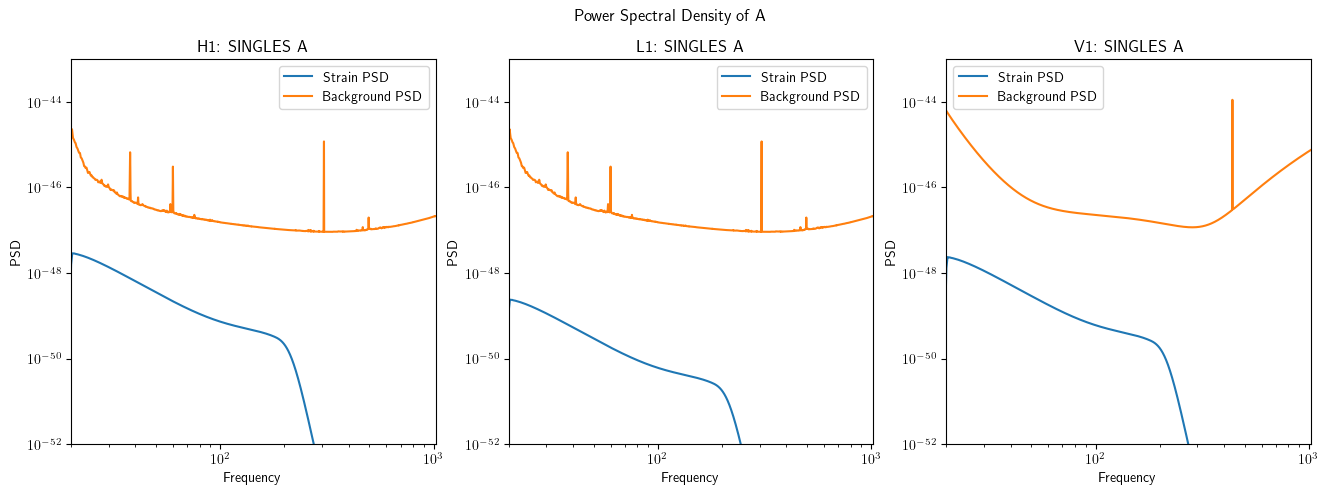

In [8]:
H1_strain_a = ifos_a[0].time_domain_strain
L1_strain_a = ifos_a[1].time_domain_strain
V1_strain_a = ifos_a[2].time_domain_strain

freq_a, H1_strain_a_psd = sig.welch(H1_strain_a, fs=sampling_frequency, nperseg=int(sampling_frequency * 4))
freq_a, L1_strain_a_psd = sig.welch(L1_strain_a, fs=sampling_frequency, nperseg=int(sampling_frequency * 4))
freq_a, V1_strain_a_psd = sig.welch(V1_strain_a, fs=sampling_frequency, nperseg=int(sampling_frequency * 4))

H1_a_bg_psd = ifos_a[0].power_spectral_density.psd_array
L1_a_bg_psd = ifos_a[1].power_spectral_density.psd_array
V1_a_bg_psd = ifos_a[2].power_spectral_density.psd_array
freq_a_bg = ifos_a[0].power_spectral_density.frequency_array
freq_a_bg_V1 = ifos_a[2].power_spectral_density.frequency_array

fig = plt.figure(figsize=(16, 5))
fig.suptitle('Power Spectral Density of A')

ax1 = plt.subplot(131)
ax1.loglog(freq_a, H1_strain_a_psd, label='Strain PSD')
ax1.loglog(freq_a_bg, H1_a_bg_psd, label='Background PSD')
ax1.set_title('H1: SINGLES A')
ax1.set_xlim(20, 1024)
ax1.set_ylim(1e-52, 1e-43)
ax1.set_xlabel('Frequency')
ax1.set_ylabel('PSD')
ax1.legend()

ax2 = plt.subplot(132)
ax2.loglog(freq_a, L1_strain_a_psd, label='Strain PSD')
ax2.loglog(freq_a_bg, L1_a_bg_psd, label='Background PSD')
ax2.set_title('L1: SINGLES A')
ax2.set_xlim(20, 1024)
ax2.set_ylim(1e-52, 1e-43)
ax2.set_xlabel('Frequency')
ax2.set_ylabel('PSD')
ax2.legend()

ax3 = plt.subplot(133)
ax3.loglog(freq_a, V1_strain_a_psd, label='Strain PSD')
ax3.loglog(freq_a_bg_V1, V1_a_bg_psd, label='Background PSD')
ax3.set_title('V1: SINGLES A')
ax3.set_xlim(20, 1024)
ax3.set_ylim(1e-52, 1e-43)
ax3.set_xlabel('Frequency')
ax3.set_ylabel('PSD')
ax3.legend()

plt.savefig('output/Strain - Background PSDs: A.png')

In [9]:
delta_b = np.random.uniform(0,0.5) # delta_b

injection_parameters_b = []

for idx in range(len(injection_parameters_a),len(injections["mass_1"])):
    injection_parameters_b.append(dict(deepdish.io.load('output/injections.hdf5')['injections'].loc[idx]))
    injection_parameters_b[idx-len(injection_parameters_a)]['geocent_time']+=delta_b

    waveform_generator_b = bilby.gw.WaveformGenerator(
          duration=duration, sampling_frequency=sampling_frequency, start_time=injection_parameters_b[idx-len(injection_parameters_a)]['geocent_time']- duration + 2,
          frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
          waveform_arguments=waveform_arguments)

    ifos_b = bilby.gw.detector.InterferometerList(['H1', 'L1', 'V1'])

    for ifo in ifos_b:
        ifo.minimum_frequency = minimum_frequency
        ifo.maximum_frequency = sampling_frequency/2
        ifos_b.set_strain_data_from_zero_noise(   # set_strain_data_from_power_spectral_densities
        sampling_frequency=sampling_frequency, duration=duration,
        start_time=injection_parameters_a[len(injection_parameters_a)-1]['geocent_time']- duration + 2)
    ifos_b.inject_signal(waveform_generator=waveform_generator_b, parameters=injection_parameters_b[idx-len(injection_parameters_a)])

    H1_b_snr = ifos_b.meta_data['H1']['optimal_SNR']
    L1_b_snr = ifos_b.meta_data['L1']['optimal_SNR']
    V1_b_snr = ifos_b.meta_data['V1']['optimal_SNR']
    net_b_snr = np.sqrt((H1_b_snr)**2 +(L1_b_snr)**2+(V1_b_snr)**2)
    
    if net_b_snr>8:
        break

with open('output/Waveform B Meta Data.pkl', 'wb') as file:
    pickle.dump(ifos_b.meta_data, file) 

19:16 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
19:17 bilby INFO    : Injected signal in H1:
19:17 bilby INFO    :   optimal SNR = 4.78
19:17 bilby INFO    :   matched filter SNR = 4.78+0.00j
19:17 bilby INFO    :   mass_1_source = 7.686531818481976
19:17 bilby INFO    :   mass_ratio = 0.33744550757839165
19:17 bilby INFO    :   redshift = 2.1788679184688298
19:17 bilby INFO    :   psi = 2.705220852997452
19:17 bilby INFO    :   a_1 = 0.1284553785104552
19:17 bilby INFO    :   a_2 = 0.09666905973844733
19:17 bilby INFO    :   cos_tilt_1 = -0.7408440715326656
19:17 bilby INFO    :   cos_tilt_2 = 0.9182763207919363
19:17 bilby INFO    :   phi_12 = 3.3851086119820533
19:17 bilby INFO    :   cos_theta_jn = 0.6374296031681983
19:17 bilby INFO    :   ra = 1.479390508330597
19:17 bilby INFO    : 

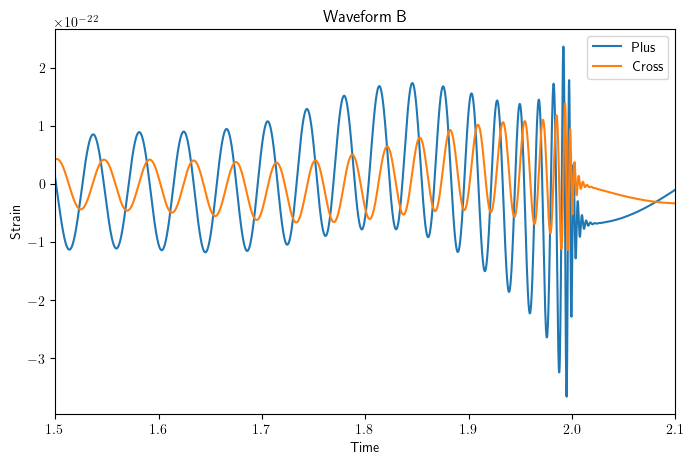

In [10]:
polarizations_td_b = waveform_generator_b.time_domain_strain(injection_parameters_b[len(injection_parameters_b)-1])
plus_td_b = np.roll(polarizations_td_b['plus'], int(sampling_frequency * 2))
cross_td_b = np.roll(polarizations_td_b['cross'], int(sampling_frequency * 2))
time = np.linspace(0, duration, len(plus_td_b))

fig = plt.figure(figsize=(8, 5))

plt.plot(time, plus_td_b, label='Plus')
plt.plot(time, cross_td_b, label='Cross')
plt.xlabel('Time')
plt.ylabel('Strain')
plt.xlim(1.5, 2.1)
plt.title('Waveform B')
plt.legend()

plt.savefig('output/Strain B.png')

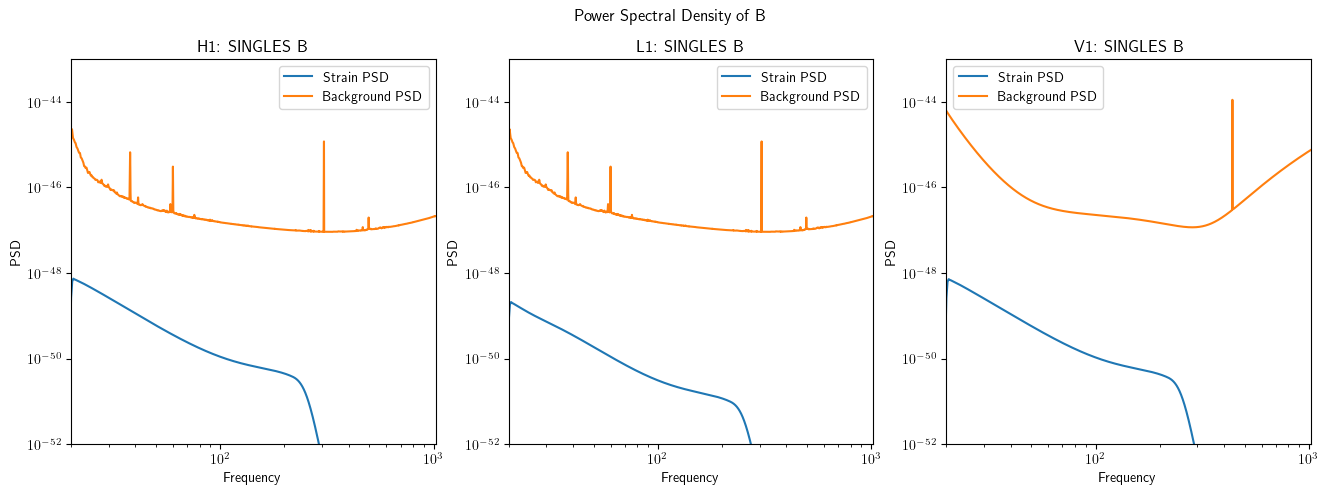

In [11]:
H1_strain_b = ifos_b[0].time_domain_strain
L1_strain_b = ifos_b[1].time_domain_strain
V1_strain_b = ifos_b[2].time_domain_strain

freq_b, H1_strain_b_psd = sig.welch(H1_strain_b, fs=sampling_frequency, nperseg=int(sampling_frequency * 4))
freq_b, L1_strain_b_psd = sig.welch(L1_strain_b, fs=sampling_frequency, nperseg=int(sampling_frequency * 4))
freq_b, V1_strain_b_psd = sig.welch(V1_strain_b, fs=sampling_frequency, nperseg=int(sampling_frequency * 4))

H1_b_bg_psd = ifos_b[0].power_spectral_density.psd_array
L1_b_bg_psd = ifos_b[1].power_spectral_density.psd_array
V1_b_bg_psd = ifos_b[2].power_spectral_density.psd_array
freq_b_bg = ifos_b[0].power_spectral_density.frequency_array
freq_b_bg_V1 = ifos_b[2].power_spectral_density.frequency_array

fig = plt.figure(figsize=(16, 5))
fig.suptitle('Power Spectral Density of B')

ax1 = plt.subplot(131)
ax1.loglog(freq_b, H1_strain_b_psd, label='Strain PSD')
ax1.loglog(freq_b_bg, H1_b_bg_psd, label='Background PSD')
ax1.set_title('H1: SINGLES B')
ax1.set_xlim(20, 1024)
ax1.set_ylim(1e-52, 1e-43)
ax1.set_xlabel('Frequency')
ax1.set_ylabel('PSD')
ax1.legend()

ax2 = plt.subplot(132)
ax2.loglog(freq_b, L1_strain_b_psd, label='Strain PSD')
ax2.loglog(freq_b_bg, L1_b_bg_psd, label='Background PSD')
ax2.set_title('L1: SINGLES B')
ax2.set_xlim(20, 1024)
ax2.set_ylim(1e-52, 1e-43)
ax2.set_xlabel('Frequency')
ax2.set_ylabel('PSD')
ax2.legend()

ax3 = plt.subplot(133)
ax3.loglog(freq_b, V1_strain_b_psd, label='Strain PSD')
ax3.loglog(freq_b_bg_V1, V1_b_bg_psd, label='Background PSD')
ax3.set_title('V1: SINGLES B')
ax3.set_xlim(20, 1024)
ax3.set_ylim(1e-52, 1e-43)
ax3.set_xlabel('Frequency')
ax3.set_ylabel('PSD')
ax3.legend()

plt.savefig('output/Strain - Background PSDs: A.png')

In [12]:
ifos = bilby.gw.detector.InterferometerList(['H1', 'L1', 'V1'])

for ifo in ifos:
    ifo.minimum_frequency = minimum_frequency
    ifo.maximum_frequency = sampling_frequency/2
    ifos.set_strain_data_from_zero_noise(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=injection_parameters_a[0]['geocent_time']-duration+2)

ifos.inject_signal(waveform_generator=waveform_generator_a, parameters=injection_parameters_a[len(injection_parameters_a)-1])
ifos.inject_signal(waveform_generator=waveform_generator_b, parameters=injection_parameters_b[len(injection_parameters_b)-1])

19:17 bilby INFO    : Injected signal in H1:
19:17 bilby INFO    :   optimal SNR = 12.85
19:17 bilby INFO    :   matched filter SNR = 12.85+0.00j
19:17 bilby INFO    :   mass_1_source = 18.612521626095766
19:17 bilby INFO    :   mass_ratio = 0.3959376299101119
19:17 bilby INFO    :   redshift = 1.982527339178439
19:17 bilby INFO    :   psi = 2.892707206567158
19:17 bilby INFO    :   a_1 = 0.18004870509728366
19:17 bilby INFO    :   a_2 = 0.048191474662374945
19:17 bilby INFO    :   cos_tilt_1 = -0.3771647970640165
19:17 bilby INFO    :   cos_tilt_2 = -0.3399602134108909
19:17 bilby INFO    :   phi_12 = 4.099906427001415
19:17 bilby INFO    :   cos_theta_jn = -0.9885557520735744
19:17 bilby INFO    :   ra = 1.1237317354821883
19:17 bilby INFO    :   dec = -0.5486854224836138
19:17 bilby INFO    :   phi_jl = 3.697210537023225
19:17 bilby INFO    :   incl = 2.914191925442208
19:17 bilby INFO    :   phase = 0.028822323598252556
19:17 bilby INFO    :   mass_1 = 55.51235460088056
19:17 bilby

[{'plus': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]),
  'cross': array([0.-0.j, 0.-0.j, 0.-0.j, ..., 0.-0.j, 0.-0.j, 0.-0.j])},
 {'plus': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]),
  'cross': array([0.-0.j, 0.-0.j, 0.-0.j, ..., 0.-0.j, 0.-0.j, 0.-0.j])},
 {'plus': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]),
  'cross': array([0.-0.j, 0.-0.j, 0.-0.j, ..., 0.-0.j, 0.-0.j, 0.-0.j])}]

In [13]:
H1_strain, L1_strain, V1_strain = ifos[0].time_domain_strain, ifos[1].time_domain_strain, ifos[2].time_domain_strain
H1_strain_a, L1_strain_a, V1_strain_a, H1_strain_b, L1_strain_b, V1_strain_b = ifos_a[0].time_domain_strain, ifos_a[1].time_domain_strain, ifos_a[2].time_domain_strain, ifos_b[0].time_domain_strain, ifos_b[1].time_domain_strain, ifos_b[2].time_domain_strain
time = np.linspace(0, duration, len(H1_strain))

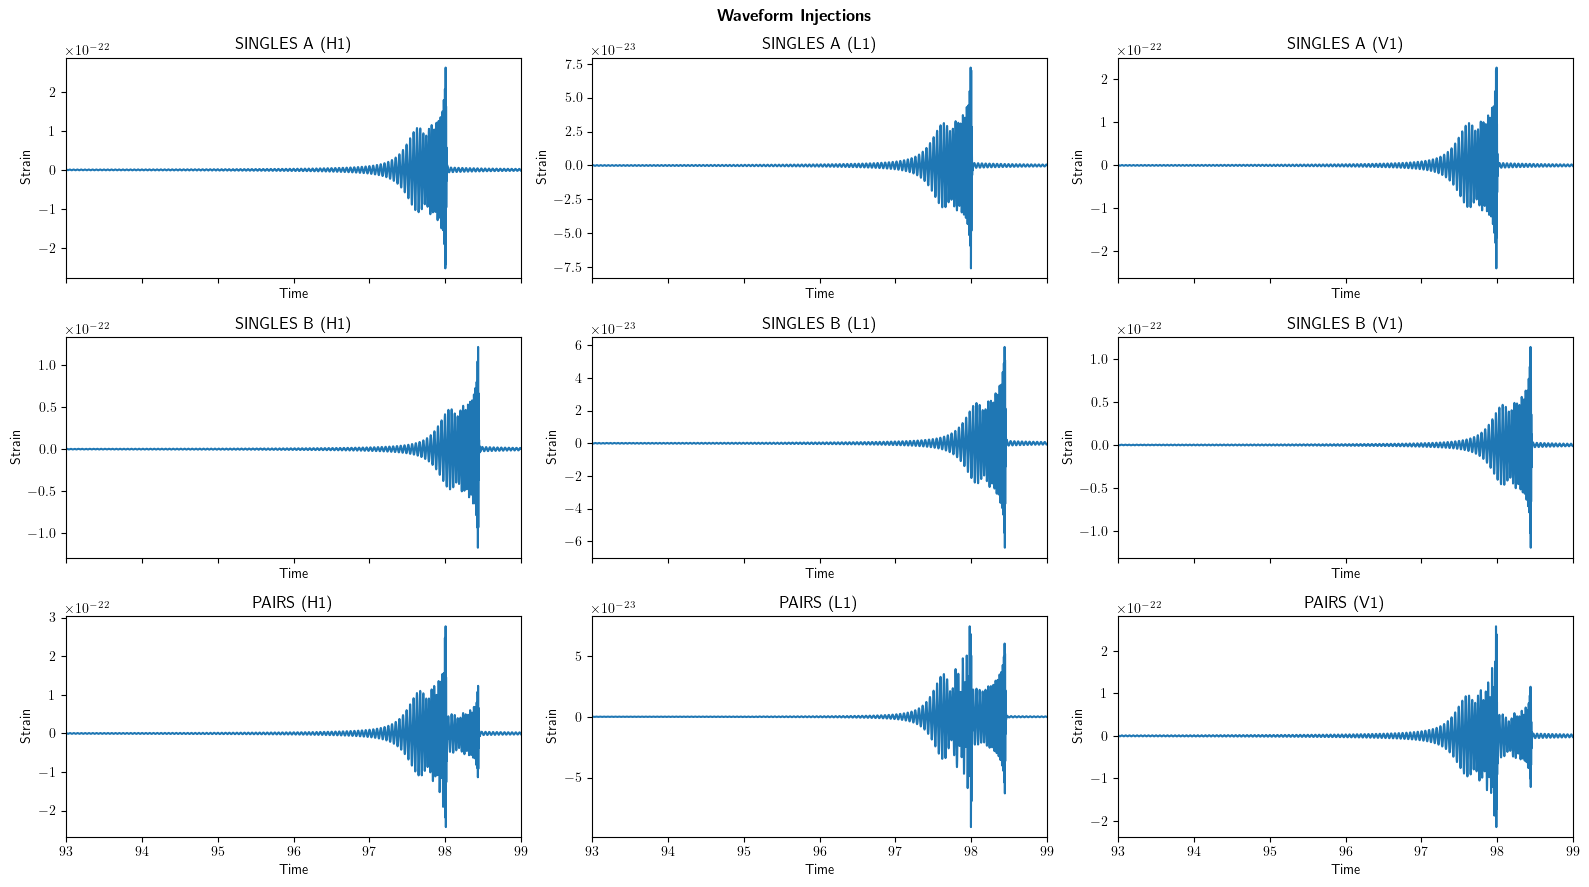

In [31]:
fig, ax = plt.subplots(3, 3, figsize=(16, 9), sharex=True)
fig.suptitle('\\textbf{Waveform Injections}')

ax[0, 0].plot(time, H1_strain_a, label='A')
ax[0, 0].set_xlim(duration-7, duration-1)
ax[0, 0].set_xlabel('Time')
ax[0, 0].set_ylabel('Strain')
ax[0, 0].set_title('SINGLES A (H1)')
ax[1, 0].plot(time, H1_strain_b, label='B')
ax[1, 0].set_xlim(duration-7, duration-1)
ax[1, 0].set_xlabel('Time')
ax[1, 0].set_ylabel('Strain')
ax[1, 0].set_title('SINGLES B (H1)')
ax[2, 0].plot(time, H1_strain, label='A+B')
ax[2, 0].set_xlim(duration-7, duration-1)
ax[2, 0].set_xlabel('Time')
ax[2, 0].set_ylabel('Strain')
ax[2, 0].set_title('PAIRS (H1)')

ax[0, 1].plot(time, L1_strain_a, label='A')
ax[0, 1].set_xlim(duration-7, duration-1)
ax[0, 1].set_xlabel('Time')
ax[0, 1].set_ylabel('Strain')
ax[0, 1].set_title('SINGLES A (L1)')
ax[1, 1].plot(time, L1_strain_b, label='B')
ax[1, 1].set_xlim(duration-7, duration-1)
ax[1, 1].set_xlabel('Time')
ax[1, 1].set_ylabel('Strain')
ax[1, 1].set_title('SINGLES B (L1)')
ax[2, 1].plot(time, L1_strain, label='A+B')
ax[2, 1].set_xlim(duration-7, duration-1)
ax[2, 1].set_xlabel('Time')
ax[2, 1].set_ylabel('Strain')
ax[2, 1].set_title('PAIRS (L1)')

ax[0, 2].plot(time, V1_strain_a, label='A')
ax[0, 2].set_xlim(duration-7, duration-1)
ax[0, 2].set_xlabel('Time')
ax[0, 2].set_ylabel('Strain')
ax[0, 2].set_title('SINGLES A (V1)')
ax[1, 2].plot(time, V1_strain_b, label='B')
ax[1, 2].set_xlim(duration-7, duration-1)
ax[1, 2].set_xlabel('Time')
ax[1, 2].set_ylabel('Strain')
ax[1, 2].set_title('SINGLES B (V1)')
ax[2, 2].plot(time, V1_strain, label='A+B')
ax[2, 2].set_xlim(duration-7, duration-1)
ax[2, 2].set_xlabel('Time')
ax[2, 2].set_ylabel('Strain')
ax[2, 2].set_title('PAIRS (V1)')

fig.set_tight_layout(True)
plt.savefig('output/Pairs Strain A+B.png')

In [15]:
start_time = injection_parameters_a[0]['geocent_time']-duration 
ht_a_H1, ht_a_L1, ht_a_V1, ht_b_H1, ht_b_L1, ht_b_V1 = TimeSeries(H1_strain_a, delta_t=1/sampling_frequency), TimeSeries(L1_strain_a, delta_t=1/sampling_frequency), TimeSeries(V1_strain_a, delta_t=1/sampling_frequency), TimeSeries(H1_strain_b, delta_t=1/sampling_frequency), TimeSeries(L1_strain_b, delta_t=1/sampling_frequency), TimeSeries(V1_strain_b, delta_t=1/sampling_frequency)
ht_H1, ht_L1, ht_V1 = TimeSeries(H1_strain, delta_t=1/sampling_frequency), TimeSeries(L1_strain, delta_t=1/sampling_frequency), TimeSeries(V1_strain, delta_t=1/sampling_frequency)
ht_a_H1.start_time, ht_a_L1.start_time, ht_a_V1.start_time, ht_b_H1.start_time, ht_b_L1.start_time, ht_b_V1.start_time, ht_H1.start_time, ht_L1.start_time, ht_V1.start_time = start_time, start_time, start_time, start_time, start_time, start_time, start_time, start_time, start_time
ht_a, ht_b, ht = {'H1': ht_a_H1, 'L1': ht_a_L1, 'V1': ht_a_V1}, {'H1': ht_b_H1, 'L1': ht_b_L1, 'V1': ht_b_V1}, {'H1': ht_H1, 'L1': ht_L1, 'V1': ht_V1}

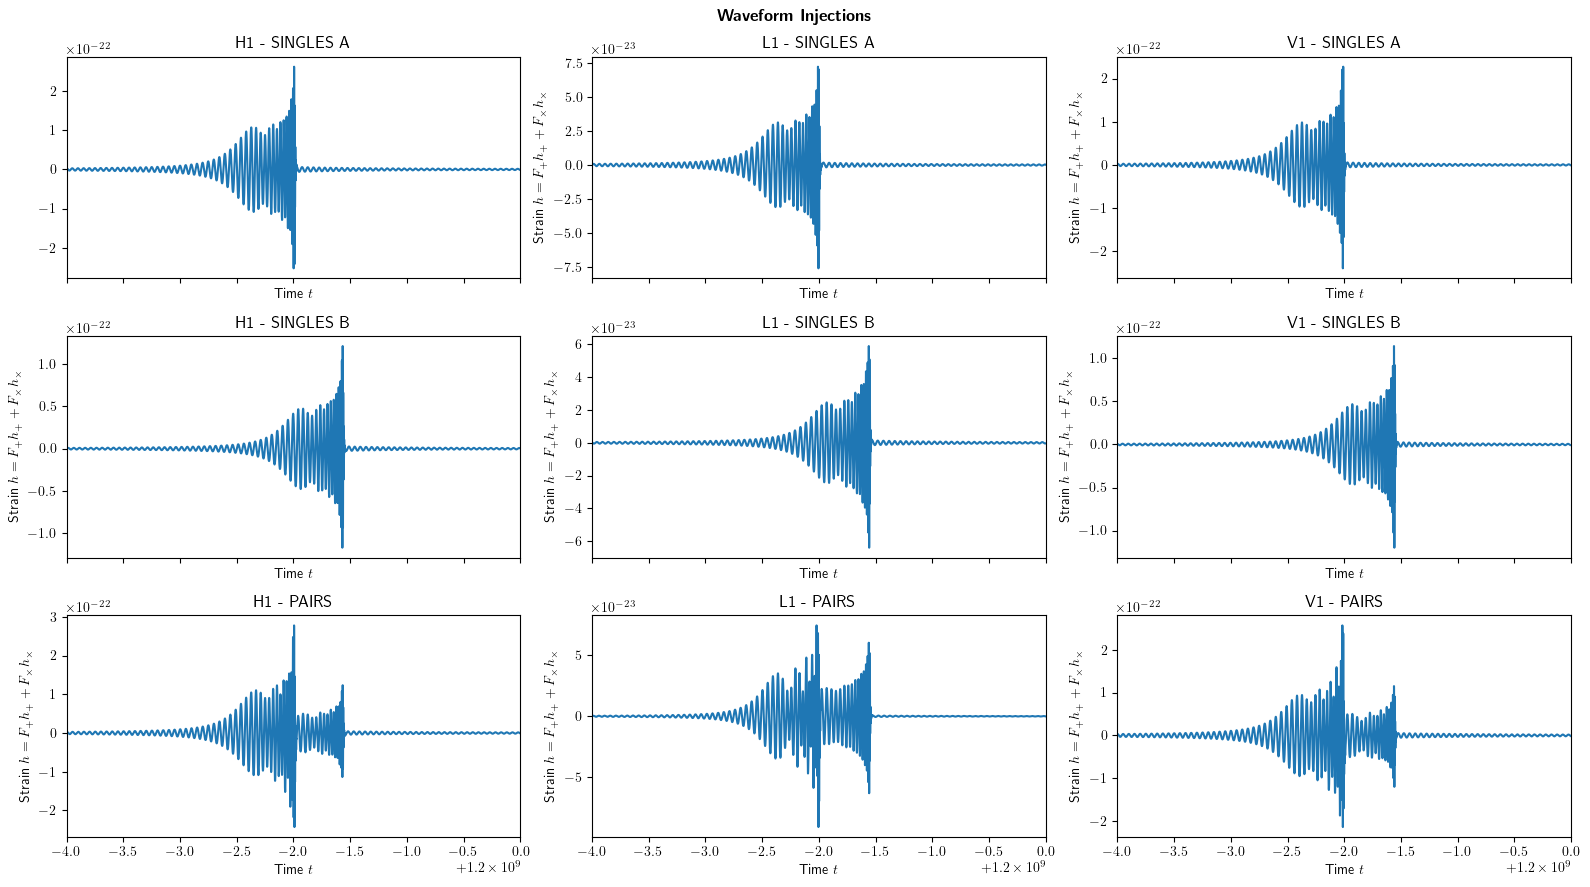

In [32]:
fig, ax = plt.subplots(3,3, figsize=(16, 9), sharex = True)
fig.suptitle('\\textbf{Waveform Injections}')

ax[0,0].plot(ht_a['H1'].sample_times, ht_a['H1'], label='$h(t)$')
ax[0,0].set_title('H1 - SINGLES A')
ax[0,0].set_xlabel('Time $t$')
ax[0,0].set_xlim(start_time+duration-4, start_time+duration)
ax[1,0].plot(ht_b['H1'].sample_times, ht_b['H1'], label='$h(t)$')
ax[1,0].set_title('H1 - SINGLES B')
ax[1,0].set_xlabel('Time $t$')
ax[1,0].set_ylabel('Strain $h=F_{+}h_{+}+F_{\\times}h_{\\times}$')
ax[2,0].plot(ht['H1'].sample_times, ht['H1'], label='$h(t)$')
ax[2,0].set_title('H1 - PAIRS')
ax[2,0].set_xlabel('Time $t$')
ax[2,0].set_ylabel('Strain $h=F_{+}h_{+}+F_{\\times}h_{\\times}$')

ax[0,1].set_ylabel('Strain $h=F_{+}h_{+}+F_{\\times}h_{\\times}$')
ax[0,1].plot(ht_a['L1'].sample_times, ht_a['L1'], label='$h(t)$')
ax[0,1].set_title('L1 - SINGLES A')
ax[0,1].set_xlabel('Time $t$')
ax[0,1].set_ylabel('Strain $h=F_{+}h_{+}+F_{\\times}h_{\\times}$')
ax[1,1].plot(ht_b['L1'].sample_times, ht_b['L1'], label='$h(t)$')
ax[1,1].set_title('L1 - SINGLES B')
ax[1,1].set_xlabel('Time $t$')
ax[1,1].set_ylabel('Strain $h=F_{+}h_{+}+F_{\\times}h_{\\times}$')
ax[2,1].plot(ht['L1'].sample_times, ht['L1'], label='$h(t)$')
ax[2,1].set_title('L1 - PAIRS')
ax[2,1].set_xlabel('Time $t$')
ax[2,1].set_ylabel('Strain $h=F_{+}h_{+}+F_{\\times}h_{\\times}$')

ax[0,2].set_ylabel('Strain $h=F_{+}h_{+}+F_{\\times}h_{\\times}$')
ax[0,2].plot(ht_a['V1'].sample_times, ht_a['V1'], label='$h(t)$')
ax[0,2].set_title('V1 - SINGLES A')
ax[0,2].set_xlabel('Time $t$')
ax[0,2].set_ylabel('Strain $h=F_{+}h_{+}+F_{\\times}h_{\\times}$')
ax[1,2].plot(ht_b['V1'].sample_times, ht_b['V1'], label='$h(t)$')
ax[1,2].set_title('V1 - SINGLES B')
ax[1,2].set_xlabel('Time $t$')
ax[1,2].set_ylabel('Strain $h=F_{+}h_{+}+F_{\\times}h_{\\times}$')
ax[2,2].plot(ht['V1'].sample_times, ht['V1'], label='$h(t)$')
ax[2,2].set_title('V1 - PAIRS')
ax[2,2].set_xlabel('Time $t$')
ax[2,2].set_ylabel('Strain $h=F_{+}h_{+}+F_{\\times}h_{\\times}$')

fig.set_tight_layout(True)
plt.savefig('output/Singles & Pairs.png')